In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.plotly as py
import plotly.graph_objs as go 
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min 
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics 
from sklearn.metrics import davies_bouldin_score 
import hdbscan 
from scipy.cluster.hierarchy import linkage , dendrogram

#plotly.tools.set_credentials_file(username='slotbite', api_key='GYgRt3eXz6IdiIy3k7sO')
py.plotly.tools.set_credentials_file(username='cachulooo', api_key='srvpWbqoQ27WdGO3pArx')

 
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 12)

In [14]:
# Cargando datos
df = pd.read_csv("segmentacion_clientes.csv" , delimiter=";" , decimal="," , encoding='utf-8')

In [15]:
# Eliminacion de outliers (-)
df = df[df.PRODUCT_ID > 0] 
df = df[(df.FACTURACION_PROMEDIO > 0 ) & (df.FACTURACION_PROMEDIO <= 397000 )] 
df = df[(df.SALDO_PROMEDIO > 0 ) & (df.SALDO_PROMEDIO <= 401500 )]  


## Convertimos las variables categoricas
#http://pbpython.com/categorical-encoding.html
pd.options.mode.chained_assignment = None
df["COMUNA"] = df["COMUNA"].astype('category')
df["TIPO_REPARTO"] = df["TIPO_REPARTO"].astype('category')
df["TI"] = df["TI"].astype('category')
df["TI2"] = df["TI2"].astype('category')

# luego la encodificamos 
df["TI"] = df["TI"].cat.codes
df["TI2"] = df["TI2"].cat.codes
df["COMUNA_ENC"] = df["COMUNA"].cat.codes 
df["TIPO_REPARTO"] = df["TIPO_REPARTO"].cat.codes 
df[:3]

,PRODUCT_ID,SUBSCRIPTION_ID,SUBSCRIBER_ID,COMUNA,TI,TI2,TIPO_REPARTO,QUEJAS,DAÑOS,CORTES,RECLAMOS,FACTURACION_PROMEDIO,SALDO_PROMEDIO,ROTACION_CARTERA,COMUNA_ENC
0,122551,122551,13185036,128 - San Esteban ...,0,0,0,0,0,0,0,18964.8333,33256.6667,1.753504,8
1,122581,122581,122581,128 - San Esteban ...,0,0,0,0,0,0,0,28445.7500,36605.0833,1.286793,8
2,109938,109938,3665521,145 - San Felipe ...,0,1,0,0,0,1,0,135045.4170,327823.5000,2.427488,18


In [16]:
columnas = df.columns
columnas

Index(['PRODUCT_ID', 'SUBSCRIPTION_ID', 'SUBSCRIBER_ID', 'COMUNA', 'TI', 'TI2',
       'TIPO_REPARTO', 'QUEJAS', 'DAÑOS', 'CORTES', 'RECLAMOS',
       'FACTURACION_PROMEDIO', 'SALDO_PROMEDIO', 'ROTACION_CARTERA',
       'COMUNA_ENC'],
      dtype='object')

In [19]:
frac= 0.001
random = 42  
sample= df[['TI', 'TI2',
       'TIPO_REPARTO', 'QUEJAS', 'DAÑOS', 'CORTES', 'RECLAMOS',
       'FACTURACION_PROMEDIO', 'SALDO_PROMEDIO', 'ROTACION_CARTERA',
       'COMUNA_ENC']].sample(frac=frac , random_state=random)

In [20]:
mergings = linkage(sample , method='complete')

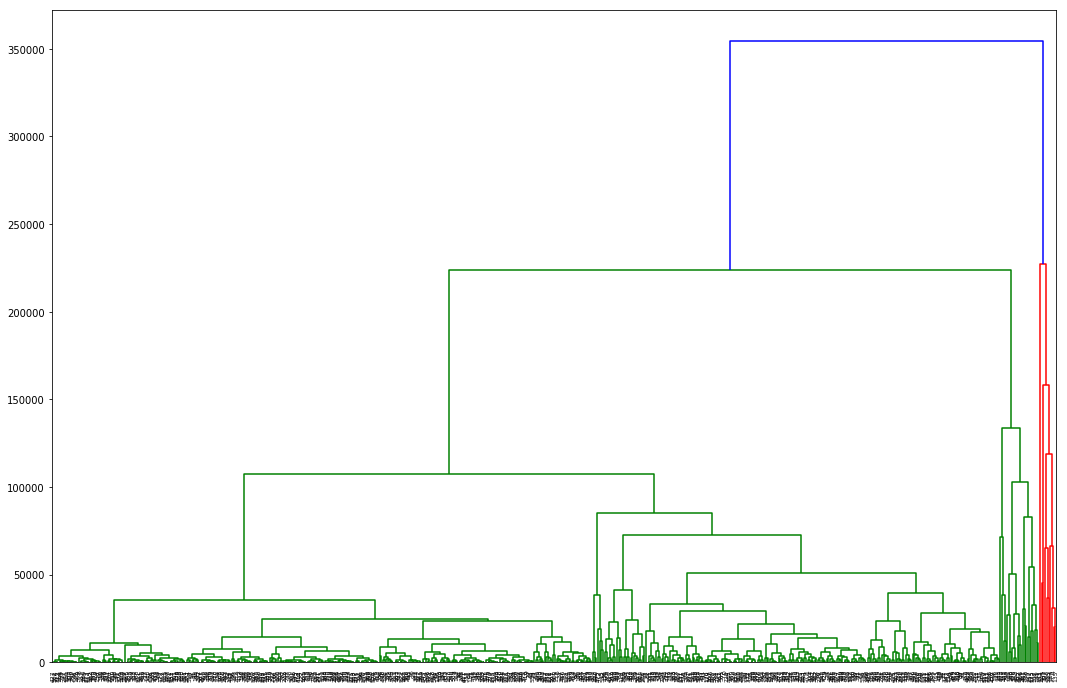

In [24]:
dendrogram(mergings , leaf_rotation=90 , leaf_font_size=6)
plt.show()